In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [2]:
!nvidia-smi

Sat Sep 21 12:52:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from torch_geometric.nn import RGCNConv

from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Load graph
view=5
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [7]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1590078  Test:454306  Validation: 227152


In [13]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [14]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 125], [True, 31354]]


In [15]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def encode(self, x, edge_index, edge_type):
        edge_type = edge_type.view(-1)
        x = self.conv1(x, edge_index, edge_type).relu()
        return self.conv2(x, edge_index, edge_type)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [16]:
num_relations = len(pred_mapping)
model = Net(train_data.num_features, 32, 64, num_relations).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
def train():
    model.train()
    optimizer.zero_grad()

    # Flatten edge_type to make sure it's 1D
    edge_type = train_data.edge_type.view(-1)  # Ensure it's 1D

    z = model.encode(train_data.x, train_data.edge_index, edge_type)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()


In [18]:
@torch.no_grad()
def test(data):
    model.eval()
    edge_type = data.edge_type.view(-1)  # Ensure edge_type is 1D

    z = model.encode(data.x, data.edge_index, edge_type)

    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [19]:
@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index, data.edge_type)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()

    # Ensure edge_type is 1D
    edge_type = data.edge_type.view(-1)  # Flatten edge_type to be 1D if necessary

    # Check edge_index dimensions
    if data.edge_index.dim() != 2 or data.edge_index.size(0) != 2:
        raise ValueError(f"Expected edge_index with shape [2, num_edges], but got {data.edge_index.shape}")

    z = model.encode(data.x, data.edge_index, data.edge_type)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

In [20]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 62.9306
Epoch: 002, Loss: 33.6114
Epoch: 003, Loss: 19.6201
Epoch: 004, Loss: 14.1720
Epoch: 005, Loss: 11.3259
Epoch: 006, Loss: 9.9108
Epoch: 007, Loss: 8.2877
Epoch: 008, Loss: 6.7427
Epoch: 009, Loss: 5.4552
Epoch: 010, Loss: 4.5081
Epoch: 011, Loss: 3.9543
Epoch: 012, Loss: 3.6447
Epoch: 013, Loss: 3.3504
Epoch: 014, Loss: 3.0341
Epoch: 015, Loss: 2.7553
Epoch: 016, Loss: 2.4773
Epoch: 017, Loss: 2.2633
Epoch: 018, Loss: 2.0787
Epoch: 019, Loss: 1.9086
Epoch: 020, Loss: 1.7667
Epoch: 021, Loss: 1.6423
Epoch: 022, Loss: 1.5382
Epoch: 023, Loss: 1.4432
Epoch: 024, Loss: 1.3634


In [21]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 1.2944
Epoch: 002, Loss: 1.2264
Epoch: 003, Loss: 1.1752
Epoch: 004, Loss: 1.1248
Epoch: 005, Loss: 1.0875
Epoch: 006, Loss: 1.0473
Epoch: 007, Loss: 1.0165
Epoch: 008, Loss: 0.9836
Epoch: 009, Loss: 0.9577
Epoch: 010, Loss: 0.9332
Epoch: 011, Loss: 0.9096
Epoch: 012, Loss: 0.8895
Epoch: 013, Loss: 0.8693
Epoch: 014, Loss: 0.8536
Epoch: 015, Loss: 0.8354
Epoch: 016, Loss: 0.8230
Epoch: 017, Loss: 0.8102
Epoch: 018, Loss: 0.7982
Epoch: 019, Loss: 0.7864
Epoch: 020, Loss: 0.7773
Epoch: 021, Loss: 0.7695
Epoch: 022, Loss: 0.7596
Epoch: 023, Loss: 0.7527
Epoch: 024, Loss: 0.7457
Epoch: 025, Loss: 0.7384
Epoch: 026, Loss: 0.7326
Epoch: 027, Loss: 0.7281
Epoch: 028, Loss: 0.7230
Epoch: 029, Loss: 0.7190
Epoch: 030, Loss: 0.7144
Epoch: 031, Loss: 0.7110
Epoch: 032, Loss: 0.7073
Epoch: 033, Loss: 0.7045
Epoch: 034, Loss: 0.7005
Epoch: 035, Loss: 0.6995
Epoch: 036, Loss: 0.6948
Epoch: 037, Loss: 0.6939
Epoch: 038, Loss: 0.6908
Epoch: 039, Loss: 0.6882
Epoch: 040, Loss: 0.6862


In [22]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6720
Epoch: 002, Loss: 0.6711
Epoch: 003, Loss: 0.6694
Epoch: 004, Loss: 0.6684
Epoch: 005, Loss: 0.6670
Epoch: 006, Loss: 0.6667
Epoch: 007, Loss: 0.6657
Epoch: 008, Loss: 0.6644
Epoch: 009, Loss: 0.6632
Epoch: 010, Loss: 0.6636
Epoch: 011, Loss: 0.6618
Epoch: 012, Loss: 0.6612
Epoch: 013, Loss: 0.6601
Epoch: 014, Loss: 0.6599
Epoch: 015, Loss: 0.6598
Epoch: 016, Loss: 0.6591
Epoch: 017, Loss: 0.6576
Epoch: 018, Loss: 0.6572
Epoch: 019, Loss: 0.6569
Epoch: 020, Loss: 0.6561
Epoch: 021, Loss: 0.6555
Epoch: 022, Loss: 0.6556
Epoch: 023, Loss: 0.6554
Epoch: 024, Loss: 0.6541


In [23]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6537
Epoch: 002, Loss: 0.6536
Epoch: 003, Loss: 0.6527
Epoch: 004, Loss: 0.6525
Epoch: 005, Loss: 0.6521
Epoch: 006, Loss: 0.6520
Epoch: 007, Loss: 0.6512
Epoch: 008, Loss: 0.6510
Epoch: 009, Loss: 0.6504
Epoch: 010, Loss: 0.6501
Epoch: 011, Loss: 0.6494
Epoch: 012, Loss: 0.6486
Epoch: 013, Loss: 0.6488
Epoch: 014, Loss: 0.6477
Epoch: 015, Loss: 0.6472
Epoch: 016, Loss: 0.6479
Epoch: 017, Loss: 0.6466
Epoch: 018, Loss: 0.6467
Epoch: 019, Loss: 0.6463
Epoch: 020, Loss: 0.6465
Epoch: 021, Loss: 0.6461
Epoch: 022, Loss: 0.6452
Epoch: 023, Loss: 0.6455
Epoch: 024, Loss: 0.6449
Epoch: 025, Loss: 0.6447
Epoch: 026, Loss: 0.6440
Epoch: 027, Loss: 0.6439
Epoch: 028, Loss: 0.6442
Epoch: 029, Loss: 0.6438
Epoch: 030, Loss: 0.6427
Epoch: 031, Loss: 0.6426
Epoch: 032, Loss: 0.6425
Epoch: 033, Loss: 0.6422
Epoch: 034, Loss: 0.6425
Epoch: 035, Loss: 0.6415
Epoch: 036, Loss: 0.6414
Epoch: 037, Loss: 0.6414
Epoch: 038, Loss: 0.6413
Epoch: 039, Loss: 0.6404
Epoch: 040, Loss: 0.6402


In [24]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6378
Epoch: 002, Loss: 0.6383
Epoch: 003, Loss: 0.6377
Epoch: 004, Loss: 0.6379
Epoch: 005, Loss: 0.6379
Epoch: 006, Loss: 0.6369
Epoch: 007, Loss: 0.6375
Epoch: 008, Loss: 0.6373
Epoch: 009, Loss: 0.6366
Epoch: 010, Loss: 0.6367
Epoch: 011, Loss: 0.6370
Epoch: 012, Loss: 0.6368
Epoch: 013, Loss: 0.6365
Epoch: 014, Loss: 0.6364
Epoch: 015, Loss: 0.6357
Epoch: 016, Loss: 0.6359
Epoch: 017, Loss: 0.6353
Epoch: 018, Loss: 0.6353
Epoch: 019, Loss: 0.6354
Epoch: 020, Loss: 0.6350
Epoch: 021, Loss: 0.6352
Epoch: 022, Loss: 0.6351
Epoch: 023, Loss: 0.6346
Epoch: 024, Loss: 0.6346
Epoch: 025, Loss: 0.6345
Epoch: 026, Loss: 0.6340
Epoch: 027, Loss: 0.6340
Epoch: 028, Loss: 0.6343
Epoch: 029, Loss: 0.6336
Epoch: 030, Loss: 0.6339
Epoch: 031, Loss: 0.6335
Epoch: 032, Loss: 0.6334
Epoch: 033, Loss: 0.6332
Epoch: 034, Loss: 0.6335
Epoch: 035, Loss: 0.6332
Epoch: 036, Loss: 0.6329
Epoch: 037, Loss: 0.6327
Epoch: 038, Loss: 0.6330
Epoch: 039, Loss: 0.6325
Epoch: 040, Loss: 0.6325


In [25]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6315
Epoch: 002, Loss: 0.6313
Epoch: 003, Loss: 0.6313
Epoch: 004, Loss: 0.6314
Epoch: 005, Loss: 0.6311
Epoch: 006, Loss: 0.6309
Epoch: 007, Loss: 0.6309
Epoch: 008, Loss: 0.6308
Epoch: 009, Loss: 0.6304
Epoch: 010, Loss: 0.6304
Epoch: 011, Loss: 0.6306
Epoch: 012, Loss: 0.6304
Epoch: 013, Loss: 0.6303
Epoch: 014, Loss: 0.6300
Epoch: 015, Loss: 0.6304
Epoch: 016, Loss: 0.6300
Epoch: 017, Loss: 0.6297
Epoch: 018, Loss: 0.6301
Epoch: 019, Loss: 0.6297
Epoch: 020, Loss: 0.6299
Epoch: 021, Loss: 0.6296
Epoch: 022, Loss: 0.6297
Epoch: 023, Loss: 0.6298
Epoch: 024, Loss: 0.6296
Epoch: 025, Loss: 0.6293
Epoch: 026, Loss: 0.6294
Epoch: 027, Loss: 0.6294
Epoch: 028, Loss: 0.6294
Epoch: 029, Loss: 0.6293
Epoch: 030, Loss: 0.6291
Epoch: 031, Loss: 0.6293
Epoch: 032, Loss: 0.6290
Epoch: 033, Loss: 0.6289
Epoch: 034, Loss: 0.6289
Epoch: 035, Loss: 0.6286
Epoch: 036, Loss: 0.6284
Epoch: 037, Loss: 0.6283
Epoch: 038, Loss: 0.6286
Epoch: 039, Loss: 0.6283
Epoch: 040, Loss: 0.6284


In [26]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6279
Epoch: 002, Loss: 0.6275
Epoch: 003, Loss: 0.6276
Epoch: 004, Loss: 0.6278
Epoch: 005, Loss: 0.6273
Epoch: 006, Loss: 0.6278
Epoch: 007, Loss: 0.6274
Epoch: 008, Loss: 0.6274
Epoch: 009, Loss: 0.6270
Epoch: 010, Loss: 0.6270
Epoch: 011, Loss: 0.6268
Epoch: 012, Loss: 0.6268
Epoch: 013, Loss: 0.6271
Epoch: 014, Loss: 0.6267
Epoch: 015, Loss: 0.6267
Epoch: 016, Loss: 0.6267
Epoch: 017, Loss: 0.6264
Epoch: 018, Loss: 0.6265
Epoch: 019, Loss: 0.6268
Epoch: 020, Loss: 0.6267
Epoch: 021, Loss: 0.6268
Epoch: 022, Loss: 0.6264
Epoch: 023, Loss: 0.6263
Epoch: 024, Loss: 0.6265
Epoch: 025, Loss: 0.6258
Epoch: 026, Loss: 0.6265
Epoch: 027, Loss: 0.6265
Epoch: 028, Loss: 0.6262
Epoch: 029, Loss: 0.6260
Epoch: 030, Loss: 0.6259
Epoch: 031, Loss: 0.6260
Epoch: 032, Loss: 0.6258
Epoch: 033, Loss: 0.6258
Epoch: 034, Loss: 0.6260
Epoch: 035, Loss: 0.6257
Epoch: 036, Loss: 0.6258
Epoch: 037, Loss: 0.6260
Epoch: 038, Loss: 0.6258
Epoch: 039, Loss: 0.6258
Epoch: 040, Loss: 0.6255


In [27]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6254
Epoch: 002, Loss: 0.6254
Epoch: 003, Loss: 0.6251
Epoch: 004, Loss: 0.6253
Epoch: 005, Loss: 0.6251
Epoch: 006, Loss: 0.6250
Epoch: 007, Loss: 0.6253
Epoch: 008, Loss: 0.6246
Epoch: 009, Loss: 0.6250
Epoch: 010, Loss: 0.6249
Epoch: 011, Loss: 0.6250
Epoch: 012, Loss: 0.6246
Epoch: 013, Loss: 0.6247
Epoch: 014, Loss: 0.6247
Epoch: 015, Loss: 0.6247
Epoch: 016, Loss: 0.6245
Epoch: 017, Loss: 0.6246
Epoch: 018, Loss: 0.6247
Epoch: 019, Loss: 0.6243
Epoch: 020, Loss: 0.6245
Epoch: 021, Loss: 0.6246
Epoch: 022, Loss: 0.6243
Epoch: 023, Loss: 0.6244
Epoch: 024, Loss: 0.6248


In [28]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 5, Train: 0.8689127340030035, Val: 0.8579


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [30]:
z = get_emb(train_data)

In [31]:
y= nodes_df['type'].astype('category').cat.codes

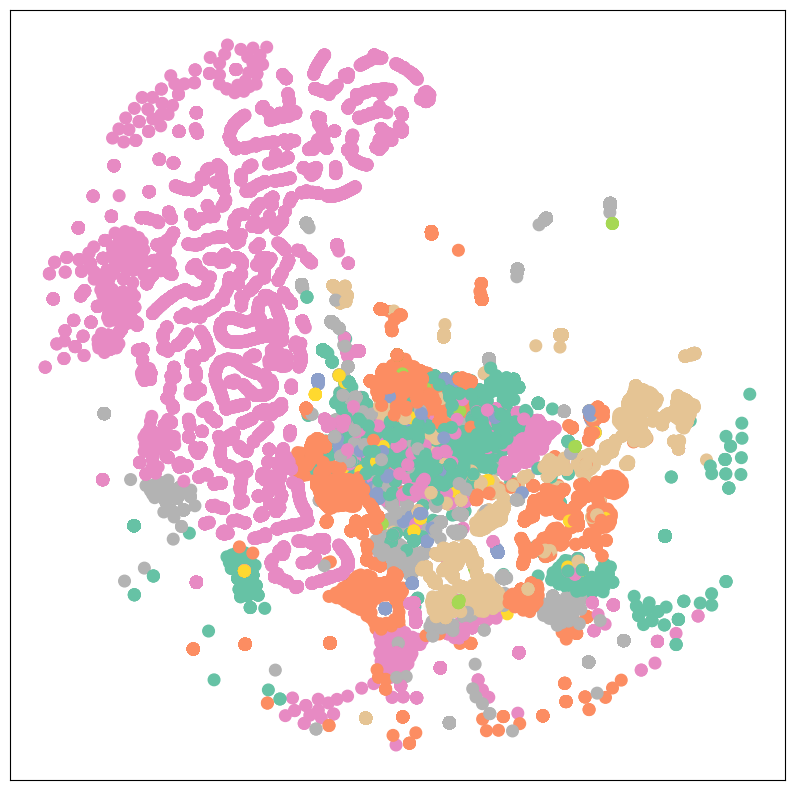

In [32]:
visualize(z,y)

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

<ipython-input-33-33f9d704249d>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


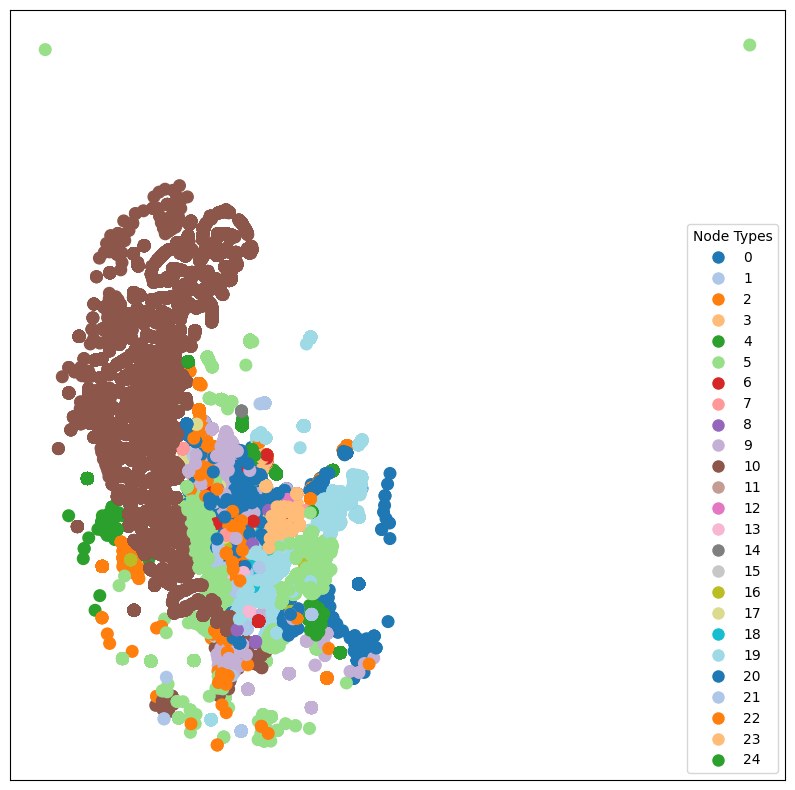

In [34]:
visualize(z,y)

In [36]:
torch.save(model, view_path+'RGCNConv_model_view'+str(view)+'.pth')

In [37]:
import os

# Define the directory and file path
view =1
view_path = f'/content/drive/MyDrive/VIEW{view}/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GNN_node_embeddings.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [38]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GNN_node_embeddings.csv')

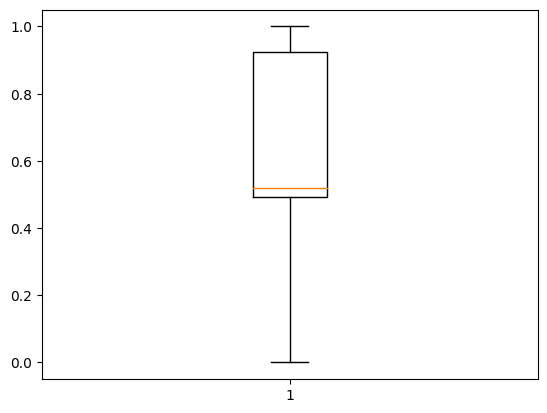

In [39]:
_=plt.boxplot(get_prob(test_data))

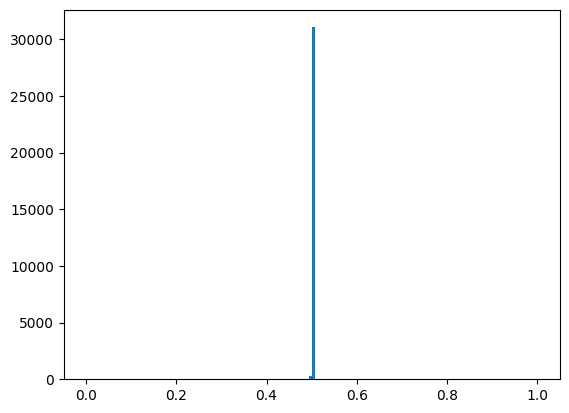

In [40]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [41]:
nodes_df

,name,type
0,<http://www.ncbi.nlm.nih.gov/gene/1163>,Gene
1,<http://purl.obolibrary.org/obo/GO_1902115>,GO
2,<http://purl.obolibrary.org/obo/MONDO_0009301>,Disease
3,<http://www.ncbi.nlm.nih.gov/gene/2692>,Gene
4,<http://purl.obolibrary.org/obo/MONDO_0000535>,Disease
...,...,...
85294,<http://purl.obolibrary.org/obo/MONDO_0012718>,Disease
85295,<https://www.mirbase.org/mature/MIMAT0002841>,miRNA
85296,<http://purl.obolibrary.org/obo/GO_0102175>,GO
85297,<http://purl.obolibrary.org/obo/HP_0500107>,Phenotype


In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [44]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9850
Precision: 0.9852
Recall: 0.9850


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [46]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [47]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW5_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

In [48]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINEv4rg.csv"
results.to_csv(filename)

In [49]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,recall,miss_rate,prevalence,balanced_accuracy,informedness,precision,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.235616,0.764384,0.5,0.517403,0.034806,0.539876,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.202370,0.797630,0.5,0.500676,0.001352,0.501675,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.235978,0.764022,0.5,0.517796,0.035592,0.540782,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.200922,0.799078,0.5,0.500423,0.000845,0.501054,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.235855,0.764145,0.5,0.517608,0.035215,0.540339,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.201415,0.798585,0.5,0.500605,0.001211,0.501507,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.236287,0.763713,0.5,0.517463,0.034927,0.539903,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.199685,0.800315,0.5,0.499511,-0.000977,0.498779,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.236213,0.763787,0.5,0.517466,0.034931,0.539922,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.199980,0.800020,0.5,0.498976,-0.002047,0.497454,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
